
## Assignment

You are leading a project to analyze product performance at Stripe. We at Stripe are most interested in how the products are performing and growing as well as how to prioritize our product development efforts to maximize our growth. You have been provided an initial cut of data on a few flagship products, each of which is targeted at a specific user segment. From the data you've been given, please prepare a short presentation detailing your findings. 

**Product Usage Table:**

|Label| Description|
| - | :- |  
| `merchant` | This is the unique ID of each Stripe user |
|`date` | Data is aggregated up to the month level for each Stripe user.|
|`product` | This is the Stripe product that the user is using to charge their customers.|
|`event` | This is an action within a product. For more details on how products are used, see "segment details" below|
|`count of events` |       |
|`usd_amount` |Total amount in cents and USD that was processed for that API call|

**Segment Table:**

This is a mapping of merchant IDs to the user segmentation we have.

|Label| Description|
| - | :- | 
|`saas`| These businesses serve SaaS products which means they primarily charge their customers on a recurring basis (usually   monthly). We want them to use our Subscriptions payments product to charge regularly on a time interval.|
|`ecommerce` | These businesses use Stripe's shopping cart product and primarily sell physical or digital goods online. |
|`platforms` | These users are platforms upon which other users can sign up and charge for services through the Stripe API. Examples would include ridesharing services, delivery services, etc. (e.g. Lyft, Task Rabbit, Instacart) |


## Segment Details

### SaaS

SaaS users have two options when they process recurring payments. The recurring payments product allows them to schedule automatically recurring payments on a fixed schedule, but the merchants can also manually create charges on Stripe for their recurring payments. Our hope with the recurring payments product is to make it easy for all users to automate their payments. The product was launched in May 2013. 

### E-Commerce Store

Our shopping cart product enables online e-commerce stores to sell goods. We track details on their website around the conversion funnel and actions that customers take. We can see when an item is viewed, added to the cart, when the checkout flow is initiated, and when it is completed with a payment submitted. 

### Platforms 

Our Marketplace product allows platforms to charge on behalf of other users and payout funds to each end automatically.



### Questions to guide thinking:

1. How are each of Stripe's products and segments performing and where are they headed?

2. Are there any issues with the products that we should address?

3. Given more time and access to more data, what would you want to dig deeper on?

4. How should we prioritize development for different products, given our limited resources?




In [199]:
import pandas as pd
import matplotlib.pyplot as plt

**Data Prep**

In [216]:
product_usage_df = pd.read_csv("product_usage.csv")# Write your code here
segmentation_df = pd.read_csv("segmentation.csv")

In [225]:
#removing empty rows 
product_usage_df = product_usage_df.dropna(how="all",axis=0)

#casting data types
product_usage_df['Merchant'] = product_usage_df['Merchant'].astype('str')
product_usage_df['Date'] = pd.to_datetime(product_usage_df['Date'],format = "%m/%d/%Y")
product_usage_df['Product'] = product_usage_df['Product'].astype('str')
product_usage_df['Event'] = product_usage_df['Event'].astype('str')
product_usage_df['Count of events'] = pd.to_numeric(product_usage_df['Count of events'],downcast='integer')
product_usage_df['Usd Amount'] = pd.to_numeric(product_usage_df['Usd Amount'],errors='coerce')
product_usage_df['Usd Amount'] = product_usage_df['Usd Amount'].fillna(0)

#removing empty columns
product_usage_df = product_usage_df.iloc[:,:6]



In [231]:
metrics_tbl = pd.merge(product_usage_df,segmentation_df,on = "Merchant",how="left")

**Based on this dataset these are some questions will be answering:**

1. How are each of Stripe's products and segments performing and where are they headed?

2. Are there any issues with the products that we should address?

3. Given more time and access to more data, what would you want to dig deeper on?

4. How should we prioritize development for different products, given our limited resources?

In [242]:
#Product and Segment Summary
metrics_tbl.groupby(['Product','Segment'])[['Count of events','Usd Amount']].sum().reset_index().rename(columns = {'Count of events':'Total Events'}).assign(**{'Total USD in Dollars' : lambda x: x['Usd Amount']/100}).drop("Usd Amount", axis = 1)

,Product,Segment,Total Events,Total USD in Dollars
0,Basic API,SaaS,54261,864776.66
1,Cart,E-Commerce Store,11943599,5585106.70
2,Marketplaces,Platform,522102,15319974.38
3,Recurring,SaaS,123992,488484.73


In [234]:
#Comparison summary of Total Events and Total USD grouped by Product, Segment, and Year
metrics_tbl['Year'] = metrics_tbl['Date'].dt.year
metrics_tbl.groupby(['Product','Segment','Year'])[['Count of events','Usd Amount']].sum().reset_index().rename(columns = {'Count of events':'Total Events'}).assign(**{'Total USD in Dollars' : lambda x: x['Usd Amount']/100}).drop("Usd Amount", axis = 1)

,Product,Segment,Year,Total Events,Total USD in Dollars
0,Basic API,SaaS,2013,8389,255072.08
1,Basic API,SaaS,2014,45872,609704.58
2,Cart,E-Commerce Store,2013,3327761,1708220.87
3,Cart,E-Commerce Store,2014,8615838,3876885.83
4,Marketplaces,Platform,2013,232075,6746691.33
5,Marketplaces,Platform,2014,290027,8573283.05
6,Recurring,SaaS,2013,18137,125435.85
7,Recurring,SaaS,2014,105855,363048.88


There seems to be a upward growth across all products and segments based on the metrics from 2013 and 2014. To ensure that we don't have any anomalies, we should drill down and compare the respective weeks

In [188]:
metrics_grouped = metrics_tbl.groupby(['Product','Segment','Date'])[['Count of events','Usd Amount']].sum().reset_index().rename(columns = {'Count of events':'Total Events'}).assign(**{'Total USD in Dollars' : lambda x: x['Usd Amount']/100}).drop("Usd Amount", axis = 1)
metrics_grouped.head()

,Product,Segment,Date,Total Events,Total USD in Dollars
0,Basic API,SaaS,2013-01-01,210,15256.48
1,Basic API,SaaS,2013-01-02,291,17515.26
2,Basic API,SaaS,2013-01-03,355,19460.07
3,Basic API,SaaS,2013-01-04,422,21902.83
4,Basic API,SaaS,2013-01-05,292,292.00


In [236]:
#Data Prep
daily_segment_df = metrics_tbl.groupby([metrics_tbl['Date'].dt.strftime('%m-%d'), 'Product', 'Segment', 'Year']).agg({
    'Usd Amount': 'sum',
    'Count of events': 'sum'
}).reset_index()

pivoted_segmented_data = daily_segment_df.pivot(index=['Date', 'Product', 'Segment'], columns='Year', values=['Usd Amount', 'Count of events'])

#get unique combinations that exist for product - segment
unique_pairs = daily_segment_df[['Product', 'Segment']].drop_duplicates().values


,Date,Product,Segment,Year,Usd Amount,Count of events
0,01-01,Basic API,SaaS,2013,1525648.0,210
1,01-01,Basic API,SaaS,2014,3590480.0,1529
2,01-01,Cart,E-Commerce Store,2013,7869838.0,156423
3,01-01,Cart,E-Commerce Store,2014,23383091.0,508542
4,01-01,Marketplaces,Platform,2013,43473945.0,15076
...,...,...,...,...,...,...
87,01-12,Cart,E-Commerce Store,2014,41962979.0,1057512
88,01-12,Marketplaces,Platform,2013,71513163.0,23760
89,01-12,Marketplaces,Platform,2014,70056757.0,24674
90,01-12,Recurring,SaaS,2013,2235463.0,3972


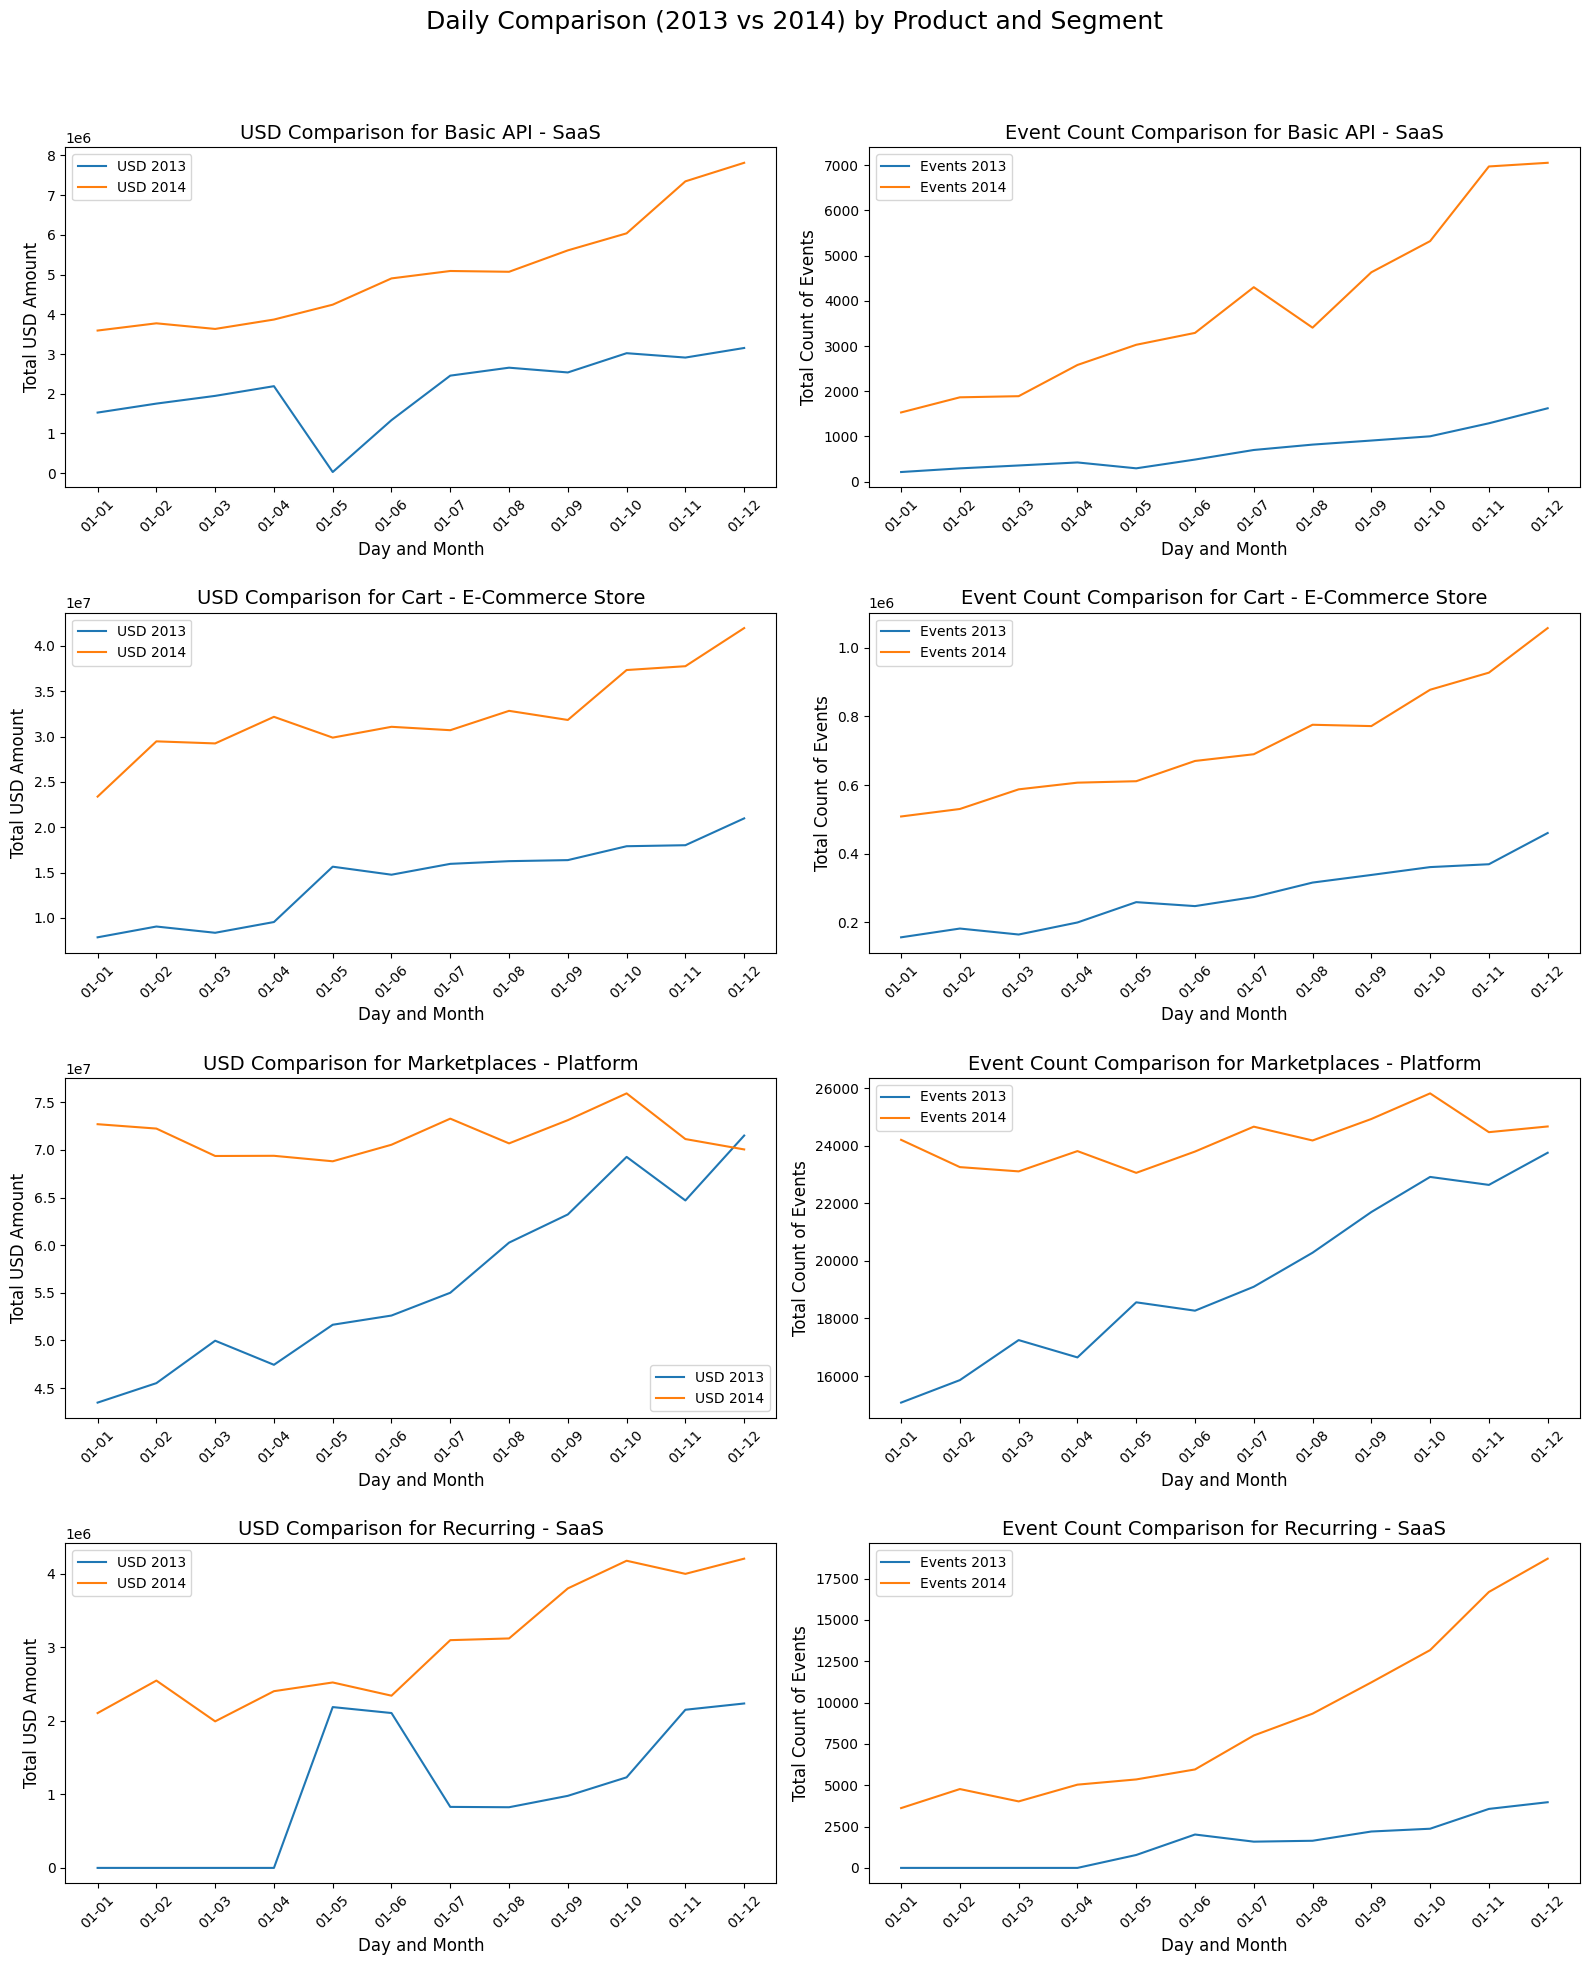

In [241]:
fig, axes = plt.subplots(nrows=len(unique_pairs), ncols=2, figsize=(16, 5 * len(unique_pairs)))
fig.suptitle('Daily Comparison (2013 vs 2014) by Product and Segment', fontsize=18)

# Iterate through each unique combination to generate separate plots
for idx, (product, segment) in enumerate(unique_pairs):
    ax_usd = axes[idx, 0]
    ax_events = axes[idx, 1]
    
    # Retrieve USD and event values for 2013 and 2014
    usd_2013 = pivoted_segmented_data.loc[(slice(None), product, segment), ('Usd Amount', 2013)].fillna(0)
    usd_2014 = pivoted_segmented_data.loc[(slice(None), product, segment), ('Usd Amount', 2014)].fillna(0)
    events_2013 = pivoted_segmented_data.loc[(slice(None), product, segment), ('Count of events', 2013)].fillna(0)
    events_2014 = pivoted_segmented_data.loc[(slice(None), product, segment), ('Count of events', 2014)].fillna(0)
    
    # Plot USD amount comparison
    ax_usd.plot(usd_2013.index.get_level_values(0), usd_2013, label='USD 2013')
    ax_usd.plot(usd_2014.index.get_level_values(0), usd_2014, label='USD 2014')
    ax_usd.set_title(f'USD Comparison for {product} - {segment}', fontsize=14)
    ax_usd.set_xlabel('Day and Month', fontsize=12)
    ax_usd.set_ylabel('Total USD Amount', fontsize=12)
    ax_usd.legend()
    ax_usd.tick_params(axis='x', rotation=45)
    
    # Plot Count of events comparison
    ax_events.plot(events_2013.index.get_level_values(0), events_2013, label='Events 2013')
    ax_events.plot(events_2014.index.get_level_values(0), events_2014, label='Events 2014')
    ax_events.set_title(f'Event Count Comparison for {product} - {segment}', fontsize=14)
    ax_events.set_xlabel('Day and Month', fontsize=12)
    ax_events.set_ylabel('Total Count of Events', fontsize=12)
    ax_events.legend()
    ax_events.tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



**1. How are each of Stripe's products and segments performing and where are they headed?**


There is a noticable growth in revenue across most product - segment combinations from 2013 to 2014. Marketplaces and Cart saw a significant increase which is reflected by both the rise of volume in transaction and larger transactions. 

The count of events also rose across the combinations particularly in E-Commerce and SaaS, this indicates that there's a growing customer base and higher user engagement

The trends highlights that there's a strong year over year growth, suggesting effective marketing strategies, expansion in customer acquisition, and increased engagment across products and segments




**2. Are there any issues with the products that we should address?**

There seems to be a sharp growth in events but moderate growth in revenue in the Recurring SaaS segment. This could suggest that there's a potential increase in lower tier or downsell churn.

We can try to educate the customers on the benefits of higher tier subsctiptions and highlight features that may add value to their business and emphasize long term savings. 



**3. Given more time and access to more data, what would you want to dig deeper on?**


If I had more time and access to more data I would like to analyze the potential cause for the disproptional mismatch between the Count of events and Revenue. It could be signaling that we need to adjust the pricing structure if there is an increase in down sell. 

**4. How should we prioritize development for different products, given our limited resources?**

I think that we should be collecting and analyzing customer feedback to better understand and prioritize their pain points and needs. This will help us align customer needs with the growing market segments or untapped opportunities.
